<a href="https://colab.research.google.com/github/datascience-uniandes/classification_tutorial/blob/master/churn/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing: Detección de cancelación de clientes

MINE-4101: Applied Data Science  
Univerisdad de los Andes  
  
Last update: Noviembre 2024

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade scikit-learn imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc


In [5]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imblearn version:", imblearn.__version__)


scikit-learn version: 1.5.2
imblearn version: 0.12.4


In [6]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Carga y entendimiento de datos

Vamos a cargar y caracterizar rápidamente los datos. Para ver este proceso en mayor detalle, puede revisar la práctica de clasificación original.

In [7]:
churn_df = pd.read_csv("./data/churn_train_val.csv")
test_df = pd.read_csv("./data/churn_test_labeled.csv")

In [8]:
churn_df.shape

(9000, 11)

In [9]:
test_df.shape

(1000, 11)

In [10]:
churn_df.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [11]:
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,781,Spain,Male,35,1,0.00,2,0,0,42117.90,0
1,701,Spain,Female,21,9,0.00,2,1,1,26327.42,0
2,685,Spain,Female,25,10,128509.63,1,1,0,121562.33,0
3,680,France,Male,34,3,143292.95,1,1,0,66526.01,0
4,756,Germany,Female,34,2,148200.72,1,0,0,194584.48,0


In [12]:
test_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,713,Spain,Female,48,1,163760.82,1,0,0,157381.14,1
1,502,France,Male,30,4,0.00,2,1,1,66263.87,0
2,817,Germany,Male,45,9,101207.75,1,0,0,88211.12,1
3,730,France,Male,39,1,116537.60,1,0,0,145679.60,0
4,576,Spain,Male,52,2,100549.43,2,1,1,16644.16,0


### Entrenando con un primer modelo

Vamos a usar un Árbol de Decisión como nuestro primer clasificador usando sólo algunos de los atributos.

In [13]:
features = ["age", "balance", "country", "products_number", "active_member"]

Generaremos un pipeline, con el propósito de codificar en OneHot la única columna categórica ("Country").

In [14]:
pipeline_dt = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(), ["country"])
    ], remainder="passthrough")),
    ("classifier",  DecisionTreeClassifier())
]) 

Vamos a usar GridSearch para buscar los mejores valores de 3 hiperparámetros de los árboles de decisión.

In [15]:
param_grid_dt = {
    "classifier__max_depth": [3,4,5,6,7],
    "classifier__min_samples_leaf" : [5, 10, 15],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

In [16]:
grid_dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)

In [17]:
grid_dt.fit(churn_df[features], churn_df["churn"])

c:\Users\lperd\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [5, 10, 15]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

Revisemos los mejores hiperparámetros:

In [18]:
grid_dt.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 7,
 'classifier__min_samples_leaf': 15}

Vamos a mostrar la matriz de confusión para los datos de entrenamiento y los datos de prueba.

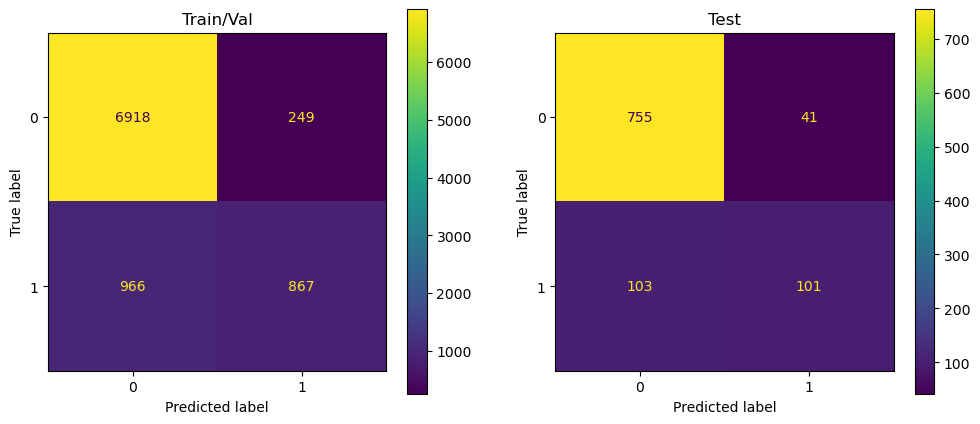

In [19]:
train_val_preds = grid_dt.best_estimator_.predict(churn_df[features])
test_preds = grid_dt.best_estimator_.predict(test_df[features])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["churn"], train_val_preds, labels=grid_dt.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_dt.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["churn"], test_preds, labels=grid_dt.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_dt.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Vemos que la precisión de la etiqueta objetivo (1= el cliente cancelará) es relativamente alta, sin embargo el recall está algo bajo. En resumen, los clientes que predecimos son en gran porcentaje los que van a cancelar, pero solo logramos detectar alrededor de la mitad de todos los clientes que van a abandonar según nuestro dataset.

In [20]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df["churn"], train_val_preds))
print("- Test:", precision_score(test_df["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["churn"], train_val_preds))
print("- Test:", recall_score(test_df["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["churn"], train_val_preds))
print("- Test:", f1_score(test_df["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["churn"], test_preds))

Accuracy:
- Train/Val: 0.865
- Test: 0.856
Precision:
- Train/Val: 0.7768817204301075
- Test: 0.7112676056338029

Recall:
- Train/Val: 0.47299509001636664
- Test: 0.4950980392156863

F1:
- Train/Val: 0.5879959308240081
- Test: 0.5838150289017341

ROC AUC:
- Train/Val: 0.7191262599516743
- Test: 0.721795250763622


## Entrenando con un segundo modelo

Vamos a intentar un nuevo modelo, esta vez un ensemble de árboles de decisión: Random Forest. Revisemos qué tal lo hace.

In [21]:
pipeline_rf = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(), ["country"])
    ], remainder="passthrough")),
    ("classifier",  RandomForestClassifier(random_state=10))
]) 

In [22]:
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth" : [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

In [23]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)


In [24]:
grid_rf.fit(churn_df[features], churn_df["churn"])


c:\Users\lperd\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

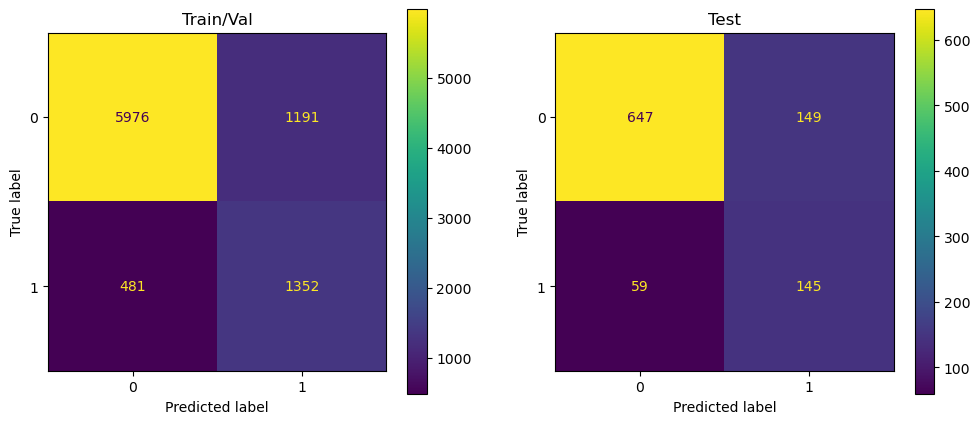

In [25]:
train_val_preds = grid_rf.best_estimator_.predict(churn_df[features])
test_preds = grid_rf.best_estimator_.predict(test_df[features])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["churn"], train_val_preds, labels=grid_rf.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_rf.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["churn"], test_preds, labels=grid_rf.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_rf.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

En este caso podemos ver que la precisión se redujo considerablemente, pero nuestro recall aumentó considerablemente.

In [26]:
grid_rf.best_params_


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 6,
 'classifier__n_estimators': 100}

In [27]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df["churn"], train_val_preds))
print("- Test:", precision_score(test_df["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["churn"], train_val_preds))
print("- Test:", recall_score(test_df["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["churn"], train_val_preds))
print("- Test:", f1_score(test_df["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["churn"], test_preds))

Accuracy:
- Train/Val: 0.8142222222222222
- Test: 0.792
Precision:
- Train/Val: 0.5316555249705073
- Test: 0.4931972789115646

Recall:
- Train/Val: 0.7375886524822695
- Test: 0.7107843137254902

F1:
- Train/Val: 0.6179159049360147
- Test: 0.5823293172690763

ROC AUC:
- Train/Val: 0.7857051675973507
- Test: 0.7617991920386246


Ahora viene la pregunta. ¿Es mejor un modelo que el otro? Para esto vamos a usar A/B Testing.

## A/B Testing

Nuestro modelo de control será el árbol de decisión original. Nuestra variante será el modelo de Random Forest.

In [28]:
control = grid_dt.best_estimator_
variant = grid_rf.best_estimator_

Vamos a dividir el conjunto de datos de prueba en dos, y vamos a predecir los valores usando cada clasificador independientemente.

In [29]:
from sklearn.model_selection import train_test_split

xtestA, xtestB, ytestA, ytestB = train_test_split(test_df[features], test_df['churn'], test_size=0.5)

In [30]:
ypred_control=control.predict(xtestA)
ypred_variant=variant.predict(xtestB)


Vamos a validar usando Exactitud general: qué tan bien en general detecta cada clasificador los clientes que se van y los que se quedan. Debido a la naturaleza desbalanceada del problema, la exactitud inicial será bastante alta:

In [31]:
acc_control = (ypred_control==ytestA).astype(int)
acc_variante = (ypred_variant==ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

0.856
0.782


In [32]:
from scipy import stats


t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 3.0990068751923787, P-value: 0.0020512704231160726


De acuerdo con esto, las distribuciones son suficientemente diferentes para indicar que si hay una diferencia significativa entre el control y la variante en términos de la Exactitud que, con alta confianza, no es producto del azar.

## Test de McNemar para la matriz de confusión

Vamos ahora a usar el [test de McNemar](https://en.wikipedia.org/wiki/McNemar%27s_test) para validar la diferencia entre ambos modelos a partir de una tabla de contingencia. Esta tabla es muy parecida a una matriz de confusión, sólo que compara los dos modelos entre sí, para determinar cuáles predicciones fueron correctas en ambos modelos, cuales incorrectas en ambas, y cuáles correctas sólo para uno de ellos. Para probar con múltiples clases es necesario probar con One vs All para cada clase (y probar si existe una diferencia significativa por clase para el clasificador), o usando el test de Cochran's Q también disponible en statsmodel.

In [33]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [34]:
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [35]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import mcnemar_tables


In [36]:
ypred_control=control.predict(test_df[features])
ypred_variant=variant.predict(test_df[features]) 

Vamos a generar nuestra tabla de contingencia

In [37]:
tb = mcnemar_tables(test_df['churn'], 
                    ypred_control, 
                    ypred_variant)

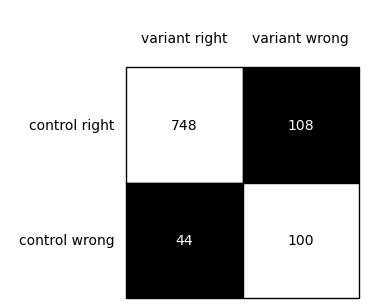

In [38]:
from mlxtend.plotting import checkerboard_plot
import matplotlib.pyplot as plt

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(3, 3),
                        fmt='%d',
                        col_labels=['variant right', 'variant wrong'],
                        row_labels=['control right', 'control wrong'])
plt.show()

Vemos acá entonces que ambos modelos predijeron correctamente las clases de 748 instancias, y ambos clasificaron incorrectamente 100 instancias. El control clasificó incorrectamente 44 instancias que la variante clasificó correctamente, mientras que la variante clasificó 108 instancias incorrectamente que el control clasificó correctamente. Hay un radio de 108:44, el control lo hizo mejor casi 2.5 veces que la variante.

In [39]:
conf_matrix = confusion_matrix(ypred_control, ypred_variant)

# Perform McNemar's test
result = mcnemar(tb['model_0 vs model_1'], exact=False)
print("McNemar’s Test Results:")
print(f"Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

McNemar’s Test Results:
Statistic: 26.111842105263158
P-value: 3.2220184411707507e-07


Al hacer el test de McNemar, nos damos cuenta que la probabilidad de que ambos modelos lo hagan igual es bastante baja (mucho menor al 5%). Luego podemos determinar que la variante es efectivamente peor que el control.

## Test para las diferentes métricas

Vamos a usar ahora el t-test 5x2cv para comparar el rendimiento de los dos modelos usando diferentes métricas. Este modelo divide los datos en 50/50 5 veces, calculando dos métricas y a partir de esto, realizando el cálculo de la estadística t.

In [40]:
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='accuracy', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.549, t-Statistic: 0.641


In [41]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='precision', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.228, t-Statistic: 1.374


In [42]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='recall', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.002, t-Statistic: -6.157


Como conclusión vemos que en términos de exactitud y precisión, ambos modelos no tienen diferencias significativas. Sin embargo, este test nos muestra que en términos de recall son suficientemente diferentes.

### ACTIVIDADES SUGERIDAS

1. Determine si los modelos son justos con relación al atributo "gender".
2. Utilice una estrategia de aumentación de datos para entrenar los modelos originales. Valide los modelos con las nuevas métricas.
3. Plantee un tercer modelo usando una *regresión logística*. Utilice pruebas A/B para determinar si su modelo es mejor o peor que el control.



<span style="color: red;">Q: How to interpret coefficients in Logistic Regression?</span>

### Justicia

In [43]:

# Añadir la variable sensible `gender` a los datos de prueba
X_test_with_gender = xtestA.copy()
# Agregar la columna 'gender' desde test_df
X_test_with_gender['gender'] = test_df.loc[xtestA.index, 'gender']


# Crear un DataFrame para análisis
results = pd.DataFrame({
    'y_true': ytestA,
    'y_pred': ypred_control,
    'gender': X_test_with_gender['gender']
})

# Separar por género
groups = results.groupby('gender')

# Métricas de equidad
metrics = {}
for group, data in groups:
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    # Cálculo de métricas por grupo
    metrics[group] = {
        'Accuracy': accuracy_score(data['y_true'], data['y_pred']),
        'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'False Negative Rate': fn / (fn + tp) if (fn + tp) > 0 else 0,
        'Positive Rate': (data['y_pred'] == 1).mean(),
        'Negative Rate': (data['y_pred'] == 0).mean(),
    }

# Mostrar métricas por grupo
metrics_df = pd.DataFrame(metrics).T
print("Fairness Metrics by Gender Group:")
print(metrics_df)

# Calcular disparidad demográfica
positive_rates = metrics_df['Positive Rate']
disparate_impact = positive_rates.min() / positive_rates.max()
print("\nDisparate Impact:", disparate_impact)

# Determinar si cumple el umbral de justicia
threshold = 0.8  # Comúnmente se usa 80%
if disparate_impact >= threshold:
    print("El modelo cumple con el criterio de justicia.")
else:
    print("El modelo no cumple con el criterio de justicia.")


ValueError: array length 1000 does not match index length 500

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

# Validar justicia con variable sensible gender
sensitive_feature = 'gender'  

# Dividir los datos por grupos
group_a = xtestA[xtestA[sensitive_feature] == 0]  
group_b = xtestA[xtestA[sensitive_feature] == 1]  

# Etiquetas verdaderas y predicciones por grupo
y_true_a = ytestA[xtestA[sensitive_feature] == 0]
y_pred_a = grid_dt.best_estimator_.predict(group_a)

y_true_b = ytestA[xtestA[sensitive_feature] == 1]
y_pred_b = grid_dt.best_estimator_.predict(group_b)

# Evaluar métricas por grupo
print("Grupo A - Masculino:")
print(confusion_matrix(y_true_a, y_pred_a))
print(classification_report(y_true_a, y_pred_a))

print("Grupo B - Femenino:")
print(confusion_matrix(y_true_b, y_pred_b))
print(classification_report(y_true_b, y_pred_b))



KeyError: 'gender'

Si las siguientes métricas varían significativamente entre los grupos, podría indicar un sesgo en el modelo.

In [45]:
from sklearn.metrics import classification_report

# Separar las predicciones por género
gender_groups = test_df['gender'].unique()  

# Diccionario para almacenar resultados
fairness_metrics = {}

# Asume que `model` es el modelo entrenado y `xtestA`, `ytestA` son los datos de prueba
for gender in gender_groups:
    # Filtrar los datos por grupo de género
    gender_mask = test_df['gender'] == gender
    x_gender = xtestA[gender_mask]
    y_gender = ytestA[gender_mask]
    
    # Obtener predicciones
    y_pred_gender = grid_rf.best_estimator_.predict(x_gender)
    
    # Calcular métricas y almacenarlas
    fairness_metrics[gender] = classification_report(
        y_gender, y_pred_gender, output_dict=True
    )

# Mostrar resultados
for gender, metrics in fairness_metrics.items():
    print(f"\nMétricas para el género {gender}:")
    print(metrics)



Métricas para el género Female:
{'0': {'precision': 0.8554216867469879, 'recall': 0.8930817610062893, 'f1-score': 0.8738461538461538, 'support': 159.0}, '1': {'precision': 0.6458333333333334, 'recall': 0.5636363636363636, 'f1-score': 0.6019417475728155, 'support': 55.0}, 'accuracy': 0.8084112149532711, 'macro avg': {'precision': 0.7506275100401607, 'recall': 0.7283590623213265, 'f1-score': 0.7378939507094846, 'support': 214.0}, 'weighted avg': {'precision': 0.8015555211500207, 'recall': 0.8084112149532711, 'f1-score': 0.8039641802712305, 'support': 214.0}}

Métricas para el género Male:
{'0': {'precision': 0.9344978165938864, 'recall': 0.9264069264069265, 'f1-score': 0.9304347826086956, 'support': 231.0}, '1': {'precision': 0.7017543859649122, 'recall': 0.7272727272727273, 'f1-score': 0.7142857142857143, 'support': 55.0}, 'accuracy': 0.8881118881118881, 'macro avg': {'precision': 0.8181261012793993, 'recall': 0.8268398268398269, 'f1-score': 0.822360248447205, 'support': 286.0}, 'weigh

C:\Users\lperd\AppData\Local\Temp\ipykernel_17456\1322967270.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_gender = xtestA[gender_mask]
C:\Users\lperd\AppData\Local\Temp\ipykernel_17456\1322967270.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_gender = xtestA[gender_mask]


El modelo no es justo con relación al género:

- Detecta mejor a los clientes que cancelan (clase 1) para el género Male.
- El desempeño global (accuracy y F1-score) es consistentemente mejor para hombres.
- Las diferencias son suficientemente significativas para indicar que el modelo tiene un sesgo a favor del género Male.

#### Aumento de datos

SMOTE

In [46]:
print("\nCompleteness analysis (null values ​​per column):")
null_values_by_column = churn_df.isnull().sum()
null_percentage_by_column = (null_values_by_column / len(churn_df)) * 100
completitud = pd.DataFrame({
    'Null Values': null_values_by_column,
    'Null Percentage': null_percentage_by_column
})
print(completitud.sort_values(by='Null Percentage', ascending=False))


Completeness analysis (null values ​​per column):
                  Null Values  Null Percentage
credit_score                0              0.0
country                     0              0.0
gender                      0              0.0
age                         0              0.0
tenure                      0              0.0
balance                     0              0.0
products_number             0              0.0
credit_card                 0              0.0
active_member               0              0.0
estimated_salary            0              0.0
churn                       0              0.0


In [47]:
print("\nCompleteness analysis (null values ​​per column):")
null_values_by_column = test_df.isnull().sum()
null_percentage_by_column = (null_values_by_column / len(test_df)) * 100
completitud = pd.DataFrame({
    'Null Values': null_values_by_column,
    'Null Percentage': null_percentage_by_column
})
print(completitud.sort_values(by='Null Percentage', ascending=False))


Completeness analysis (null values ​​per column):
                  Null Values  Null Percentage
credit_score                0              0.0
country                     0              0.0
gender                      0              0.0
age                         0              0.0
tenure                      0              0.0
balance                     0              0.0
products_number             0              0.0
credit_card                 0              0.0
active_member               0              0.0
estimated_salary            0              0.0
churn                       0              0.0


In [48]:
churn_df["age"].value_counts(dropna=False, normalize=True)

age
35    0.048778
38    0.048000
37    0.047222
36    0.045889
33    0.045111
34    0.043778
40    0.043111
39    0.043111
32    0.041667
31    0.041000
29    0.035222
41    0.035111
42    0.033222
30    0.032444
43    0.029111
28    0.027000
44    0.026000
45    0.023000
46    0.022556
27    0.020444
26    0.020333
47    0.016889
48    0.016222
49    0.015000
25    0.015000
50    0.013444
24    0.013000
51    0.011889
52    0.009889
23    0.009778
22    0.008556
54    0.008444
55    0.008000
53    0.007556
57    0.007222
56    0.007000
58    0.006444
60    0.006333
59    0.006222
61    0.005556
62    0.005444
21    0.004667
63    0.004222
20    0.004111
64    0.003667
66    0.003556
67    0.003444
71    0.002889
19    0.002667
69    0.002333
18    0.002222
72    0.002222
68    0.002000
74    0.001889
65    0.001778
70    0.001778
76    0.001222
73    0.001111
77    0.001000
75    0.000889
78    0.000556
79    0.000444
80    0.000333
84    0.000222
81    0.000222
83    0.000111
92    

In [49]:
churn_df["age"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    9000.000000
mean       38.936222
std        10.490776
min        18.000000
5%         25.000000
25%        32.000000
50%        37.000000
75%        44.000000
95%        60.000000
max        92.000000
Name: age, dtype: float64

In [50]:
churn_df["balance"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count      9000.000000
mean      76518.710529
std       62586.779039
min           0.000000
5%            0.000000
25%           0.000000
50%       97328.170000
75%      127811.165000
95%      163507.305500
max      250898.090000
Name: balance, dtype: float64

In [51]:
churn_df["country"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count       9000
unique         3
top       France
freq        4527
Name: country, dtype: object

In [52]:
churn_df["country"].value_counts(dropna=False, normalize=True)

country
France     0.503000
Spain      0.249111
Germany    0.247889
Name: proportion, dtype: float64

In [53]:
churn_df["products_number"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    9000.000000
mean        1.527778
std         0.579405
min         1.000000
5%          1.000000
25%         1.000000
50%         1.000000
75%         2.000000
95%         2.000000
max         4.000000
Name: products_number, dtype: float64

In [54]:
churn_df["active_member"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    9000.000000
mean        0.516222
std         0.499765
min         0.000000
5%          0.000000
25%         0.000000
50%         1.000000
75%         1.000000
95%         1.000000
max         1.000000
Name: active_member, dtype: float64

In [55]:
pipeline_dt_2 = Pipeline([
    ("classifier",  DecisionTreeClassifier())])

In [56]:
from sklearn.preprocessing import LabelEncoder

# Crear el codificador
encoder = LabelEncoder()

# Ajustar y transformar la columna 'country' en una sola columna numérica
churn_df['country'] = encoder.fit_transform(churn_df['country'])

# Mostrar el mapeo de categorías a números
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# Mostrar el DataFrame resultante
print(churn_df)



{'France': 0, 'Germany': 1, 'Spain': 2}
      credit_score  country  gender  age  tenure    balance  products_number  \
0              781        2    Male   35       1       0.00                2   
1              701        2  Female   21       9       0.00                2   
2              685        2  Female   25      10  128509.63                1   
3              680        0    Male   34       3  143292.95                1   
4              756        1  Female   34       2  148200.72                1   
...            ...      ...     ...  ...     ...        ...              ...   
8995           730        0  Female   35       0  155470.55                1   
8996           731        2  Female   40       5  171325.98                1   
8997           707        0    Male   29       4       0.00                2   
8998           630        0    Male   53       5  138053.67                1   
8999           591        0    Male   43       3       0.00                2   


In [57]:
test_df['country'] = encoder.fit_transform(test_df['country'])

# Mostrar el mapeo de categorías a números
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# Mostrar el DataFrame resultante
print(test_df)

{'France': 0, 'Germany': 1, 'Spain': 2}
     credit_score  country  gender  age  tenure    balance  products_number  \
0             713        2  Female   48       1  163760.82                1   
1             502        0    Male   30       4       0.00                2   
2             817        1    Male   45       9  101207.75                1   
3             730        0    Male   39       1  116537.60                1   
4             576        2    Male   52       2  100549.43                2   
..            ...      ...     ...  ...     ...        ...              ...   
995           564        2    Male   31       0  125175.58                1   
996           712        0  Female   29       3   87375.78                2   
997           647        1    Male   52       7  130013.12                1   
998           687        0    Male   35       9       0.00                2   
999           782        1  Female   53       1   81571.05                1   

     credit

In [58]:
churn_df["country"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    9000.000000
mean        0.746111
std         0.829294
min         0.000000
5%          0.000000
25%         0.000000
50%         0.000000
75%         1.000000
95%         2.000000
max         2.000000
Name: country, dtype: float64

In [59]:
from imblearn.over_sampling import SMOTE

X = churn_df.drop(columns=['churn','gender'])  # Características
y = churn_df['churn']  # Variable objetivo

# Aplicar SMOTE para generar nuevos datos sintéticos
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos aumentados
churn_df_augmented = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                 pd.DataFrame(y_resampled, columns=['churn',])], axis=1)

print("Datos originales:", churn_df.shape)
print("Datos aumentados:", churn_df_augmented.shape)


Datos originales: (9000, 11)
Datos aumentados: (14334, 10)


In [60]:
churn_df_augmented.describe()

,credit_score,country,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000,14334.000000
mean,648.573322,0.672666,40.961769,4.824055,81826.544899,1.418515,0.625924,0.374704,100819.789265,0.500000
std,91.545002,0.756569,10.054651,2.717703,61519.407463,0.570950,0.483900,0.484063,57383.282090,0.500017
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,586.000000,0.000000,34.000000,3.000000,0.000000,1.000000,0.000000,0.000000,52178.131462,0.000000
50%,650.000000,0.000000,40.000000,5.000000,102949.845000,1.000000,1.000000,0.000000,101482.735743,0.500000
75%,711.000000,1.000000,47.000000,7.000000,129741.452874,2.000000,1.000000,1.000000,149820.200000,1.000000
max,850.000000,2.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [61]:
X = test_df.drop(columns=['churn','gender'])  # Características
y = test_df['churn']  # Variable objetivo

# Aplicar SMOTE para generar nuevos datos sintéticos
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos aumentados
test_df_augmented = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                 pd.DataFrame(y_resampled, columns=['churn',])], axis=1)

print("Datos originales:", test_df.shape)
print("Datos aumentados:", test_df_augmented.shape)

Datos originales: (1000, 11)
Datos aumentados: (1592, 10)


In [62]:
features_2 = ["age", "balance", "country", "products_number", "active_member"]

In [63]:
churn_df_augmented[features_2]
churn_df_augmented["churn"]

0        0
1        0
2        0
3        0
4        0
        ..
14329    1
14330    1
14331    1
14332    1
14333    1
Name: churn, Length: 14334, dtype: int64

In [64]:
grid_dt_2 = GridSearchCV(estimator=pipeline_dt_2, param_grid=param_grid_dt, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)

In [65]:
grid_dt_2.fit(churn_df_augmented[features_2], churn_df_augmented["churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [5, 10, 15]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [66]:
grid_dt_2.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 5}

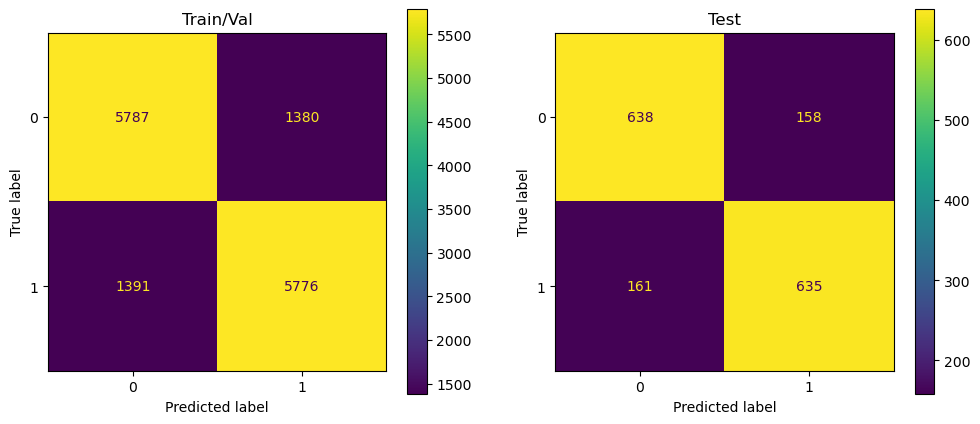

In [67]:
train_val_preds = grid_dt_2.best_estimator_.predict(churn_df_augmented[features_2])
test_preds = grid_dt_2.best_estimator_.predict(test_df_augmented[features_2])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df_augmented["churn"], train_val_preds, labels=grid_dt_2.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_dt_2.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df_augmented["churn"], test_preds, labels=grid_dt_2.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_dt_2.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

In [68]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df_augmented["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", precision_score(test_df_augmented["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", recall_score(test_df_augmented["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", f1_score(test_df_augmented["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df_augmented["churn"], test_preds))

Accuracy:
- Train/Val: 0.8066834100739501
- Test: 0.7996231155778895
Precision:
- Train/Val: 0.8071548351034097
- Test: 0.8007566204287516

Recall:
- Train/Val: 0.8059160039067951
- Test: 0.7977386934673367

F1:
- Train/Val: 0.8065349437966907
- Test: 0.7992448080553808

ROC AUC:
- Train/Val: 0.8066834100739501
- Test: 0.7996231155778895


#### Segundo modelo - random forest

In [69]:
pipeline_rf_2 = Pipeline([
    ("classifier",  RandomForestClassifier(random_state=10))])

In [70]:
grid_rf_2 = GridSearchCV(estimator=pipeline_rf_2, param_grid=param_grid_rf, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)


In [71]:
grid_rf_2.fit(churn_df_augmented[features_2], churn_df_augmented["churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

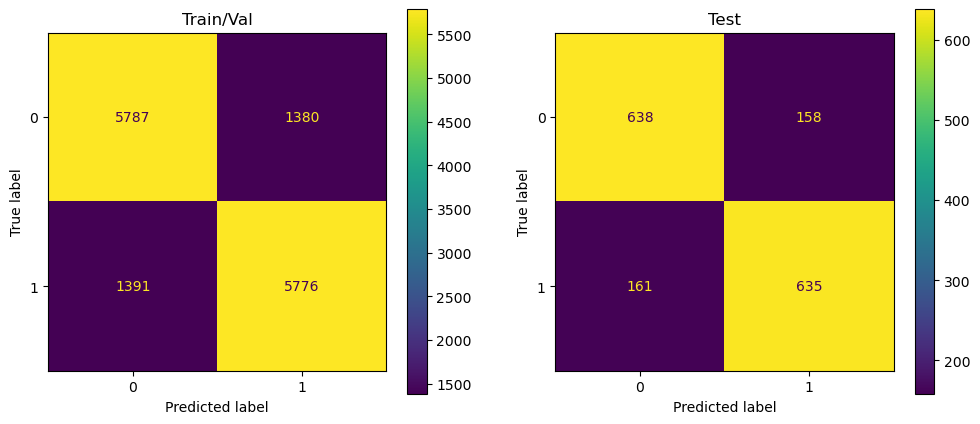

In [72]:
train_val_preds = grid_dt_2.best_estimator_.predict(churn_df_augmented[features_2])
test_preds = grid_dt_2.best_estimator_.predict(test_df_augmented[features_2])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df_augmented["churn"], train_val_preds, labels=grid_dt_2.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_dt_2.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df_augmented["churn"], test_preds, labels=grid_dt_2.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_dt_2.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

In [73]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df_augmented["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", precision_score(test_df_augmented["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", recall_score(test_df_augmented["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", f1_score(test_df_augmented["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df_augmented["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df_augmented["churn"], test_preds))

Accuracy:
- Train/Val: 0.8066834100739501
- Test: 0.7996231155778895
Precision:
- Train/Val: 0.8071548351034097
- Test: 0.8007566204287516

Recall:
- Train/Val: 0.8059160039067951
- Test: 0.7977386934673367

F1:
- Train/Val: 0.8065349437966907
- Test: 0.7992448080553808

ROC AUC:
- Train/Val: 0.8066834100739501
- Test: 0.7996231155778895


### A/B Testing con el modelo aumentado árbol de decisión

In [74]:
control = grid_dt.best_estimator_
variant = grid_dt_2.best_estimator_

In [ ]:
xtestA, xtestB, ytestA, ytestB = train_test_split(test_df_augmented[features_2], test_df_augmented['churn'], test_size=0.5)

In [82]:
ypred_control=control.predict(xtestA)
ypred_variant=variant.predict(xtestB)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
acc_control = (ypred_control==ytestA).astype(int)
acc_variante = (ypred_variant==ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

In [ ]:
t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

La prueba muestra que es estadísticamente significativa

In [ ]:
ypred_control=control.predict(test_df_augmented[features])
ypred_variant=variant.predict(test_df_augmented[features]) 

In [ ]:
tb = mcnemar_tables(test_df_augmented['churn'], 
                    ypred_control, 
                    ypred_variant)

In [ ]:

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(3, 3),
                        fmt='%d',
                        col_labels=['variant right', 'variant wrong'],
                        row_labels=['control right', 'control wrong'])
plt.show()

### A/B Testing arbol de decisión y random forest

In [83]:
control = grid_dt_2.best_estimator_
variant = grid_rf_2.best_estimator_

In [84]:
print(control)


Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                        min_samples_leaf=5))])


In [85]:
print(variant)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=6, n_estimators=50,
                                        random_state=10))])


In [86]:
xtestA, xtestB, ytestA, ytestB = train_test_split(test_df_augmented[features_2], test_df_augmented['churn'], test_size=0.5)

In [87]:
ypred_control=control.predict(xtestA)
ypred_variant=variant.predict(xtestB)

In [88]:
acc_control = (ypred_control==ytestA).astype(int)
acc_variante = (ypred_variant==ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

0.7902010050251256
0.8153266331658291


In [89]:
t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.255365521303918, P-value: 0.20971495982176386


Con el aumento de datos se evidencia que el modelo de random forest tiene un mejor desempeño, por lo que al aplicar la prueba estadística no hay una diferencia estadísticamente significativa al tener un p-values mayor a 0.05

### Regresión Logística

In [90]:
# Creating feature matrix
X = churn_df[features]
# Creating target
Y = churn_df["churn"]

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=500)

In [92]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Initializing the model
model = LogisticRegression(penalty="l2", C=0.1, solver="liblinear", class_weight="balanced", random_state=80)
# Training the model using training dataset
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=80,
                   solver='liblinear')

In [93]:
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=80,
                   solver='liblinear')

In [94]:
pd.DataFrame(np.append(np.array(features).reshape(-1, 1), model.coef_.reshape(-1, 1), axis=1), columns=["feature", "coefficient"])

,feature,coefficient
0,age,0.8137105124212332
1,balance,0.307652363024027
2,country,0.06430878080947736
3,products_number,-0.016692125591588374
4,active_member,-0.43066084291534196


Los coeficientes indican cómo afecta un aumento en la variable correspondiente a la probabilidad del resultado (usualmente la probabilidad de que la variable objetivo sea 1).

Reglas básicas:
- Coeficiente positivo: Un aumento en la variable incrementa la probabilidad del evento (es decir, el resultado se inclina hacia 1).
- Coeficiente negativo: Un aumento en la variable reduce la probabilidad del evento (el resultado se inclina hacia 0).
Magnitud del coeficiente: Cuanto mayor sea el valor absoluto del coeficiente, más fuerte es la influencia de esa variable.

__________________________________________________________________________________________________________________________

- age (0.8137)	Positivo y significativo. Cada aumento en la edad incrementa la probabilidad del evento (por ejemplo, de realizar una acción o pertenecer a una categoría).	

- balance (0.3077)	Positivo. Un mayor balance está asociado con una mayor probabilidad de que ocurra el evento.	
- country (0.0643)	Positivo, pero de menor impacto. El país tiene una leve influencia en la probabilidad del evento.	
- products_number (-0.0167)	Negativo y pequeño. Tener más productos está asociado con una reducción muy ligera en la probabilidad del evento.	
- active_member (-0.4307)	Negativo. Ser un miembro activo disminuye la probabilidad del evento.

In [95]:
predictions = model.predict(scaler.transform(X_test))

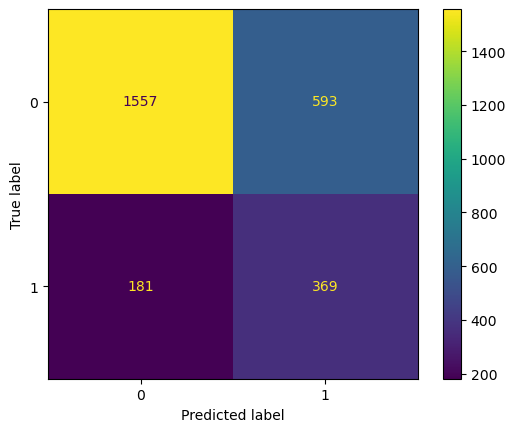

In [96]:
ConfusionMatrixDisplay.from_predictions(Y_test, predictions)

In [97]:
print("Precision:", precision_score(Y_test, predictions))
print("Recall:", recall_score(Y_test, predictions))
print("F1", f1_score(Y_test, predictions))

Precision: 0.38357588357588357
Recall: 0.6709090909090909
F1 0.4880952380952381


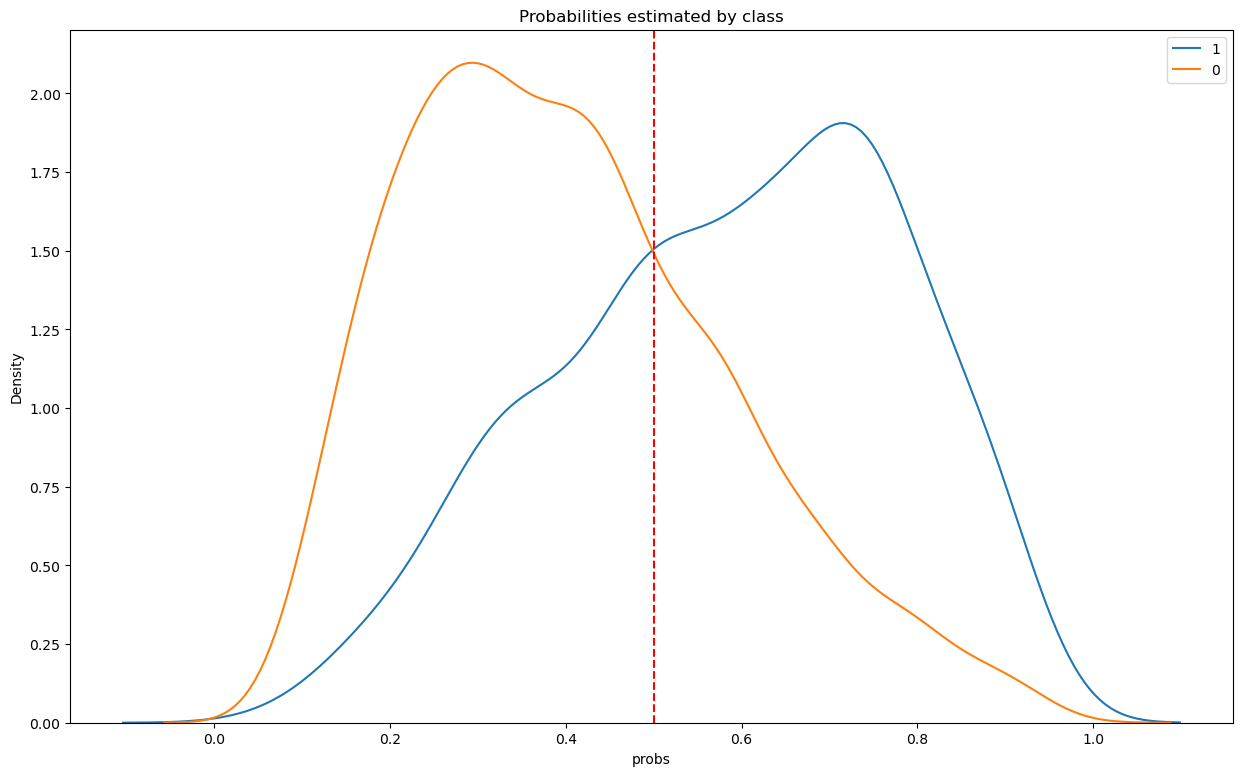

In [98]:
probabilities = model.predict_proba(scaler.transform(X_test))[:, 1]
probs_true_df = pd.DataFrame(np.append(probabilities.reshape(-1, 1), Y_test.values.reshape(-1, 1), axis=1),
                             columns=["probs", "true"])
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.title('Probabilities estimated by class')
plt.legend()
plt.show()

In [99]:
import sklearn
import imblearn

pipeline_dt = Pipeline([
    ("classifier", DecisionTreeClassifier())
])

param_grid_dt = {
    "classifier__max_depth": [3, 4, 5, 6, 7],
    "classifier__min_samples_leaf": [5, 10, 15],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}
grid_dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt,
                       scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_dt.fit(churn_df[features], churn_df["churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [5, 10, 15]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [100]:
control = grid_dt.best_estimator_
variant = model

xtestA, xtestB, ytestA, ytestB = train_test_split(test_df[features], test_df['churn'],
                                                  test_size=0.5)
ypred_control = control.predict(xtestA)
ypred_variant = variant.predict(xtestB)

acc_control = (ypred_control == ytestA).astype(int)
acc_variante = (ypred_variant == ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

0.854
0.19


c:\Users\lperd\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [101]:
t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 28.48724098541809, P-value: 1.071192931188335e-106


c:\Users\lperd\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


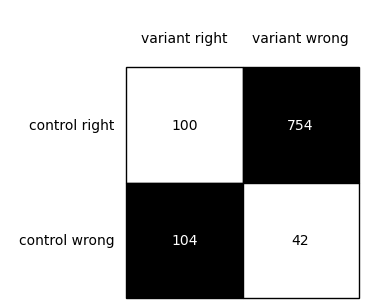

In [102]:
ypred_control = control.predict(test_df[features])
ypred_variant = variant.predict(test_df[features])

tb = mcnemar_tables(test_df['churn'],
                    ypred_control,
                    ypred_variant)
from mlxtend.plotting import checkerboard_plot
import matplotlib.pyplot as plt

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(3, 3),
                        fmt='%d',
                        col_labels=['variant right', 'variant wrong'],
                        row_labels=['control right', 'control wrong'])
plt.show()